In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pytz
from nltk import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
file_name="tweets_#superbowl.txt"
read_file=open(file_name)


In [4]:
#location determination
def loc_justify(location,discard,include):
    for word in discard:
        if word in location:
            return False
    for word in include:
        if word in location:
            return True
    return False

In [5]:
mask=[]#mask is label in further implementation
filtered_text=[]
cnt=0
for line in read_file.readlines():
    json_object=json.loads(line)
    location=json_object['tweet']['user']['location']
    location.replace(',','')
    location=location.split()
    washington=['Washington','WA','Seattle']
    mas=['Boston','MA','Massachusetts']
    washington_discard=['DC','D.C']
    judw=loc_justify(location,washington_discard,washington)
    judm=loc_justify(location,[],mas)
    if judw==True:
        mask.append(0)
        filtered_text.append(json_object['tweet']['text'])
        cnt+=1
    elif judm==True:
        mask.append(1)
        filtered_text.append(json_object['tweet']['text'])
        cnt+=1
read_file.close()
print(cnt)

33926


# Question 2

In [6]:
#Feature Extraction and Preprocessing
lemmatizer=WordNetLemmatizer()
def get_wordnet_pos(word):
    tag=nltk.pos_tag([word])[0][1][0].upper()
    tag_dict={"J":wordnet.ADJ,
              "N":wordnet.NOUN,
              "V":wordnet.VERB,
              "R":wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)

exclude_sign="~#$%^&*()[]{}<>|+=1234567890"
replace_sign="@,.?!-;"

def preprocessing(data):
    processed_sentence=[]
    for i in range(len(data)):
        sentence=data[i]
        for c in exclude_sign:
            sentence=sentence.replace(c,"")
        for c in replace_sign:
            sentence=sentence.replace(c," ")
        processed_token=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        processed_sentence.append("".join(processed_token))
    return processed_sentence

#Lemmatization
processed_data=preprocessing(filtered_text)

In [7]:
#Vectorization
stop_words=text.ENGLISH_STOP_WORDS
vectorizer=CountVectorizer(stop_words='english',min_df=3)
data_tf=vectorizer.fit_transform(filtered_text)

In [8]:
#TF-IDF transform
TdT=TfidfTransformer()
TF_data=TdT.fit_transform(data_tf)

In [9]:
#dimensionality reduction
transformer=TruncatedSVD(n_components=50)
data_svd=transformer.fit_transform(TF_data)
data_dense=TF_data.todense()

In [10]:
def plot_confusion_matrix(cm, labels, title, cmap = plt.cm.BuPu):
    plt.figure(figsize=(12,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    Title = title
    plt.title(Title, fontsize = 16)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    tick_array = np.arange(len(labels))
    x, y = np.meshgrid(tick_array, tick_array)
    for i, j in zip(x.flatten(), y.flatten()):
        plt.text(j, i, cm[i][j], ha = "center", va = "center", color = "black", fontsize = 20)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    #fig = plt.gcf()
    plt.show()
    #fig.savefig(str(cm[0][0]) + '.png', dpi=300, bbox_inches = 'tight')

# KNN

In [11]:
def KNN_evaluation(X,Y,n_neighbors):
    train=int(0.9*len(X))
    knn_model=KNeighborsClassifier(n_neighbors=n_neighbors)
    X_train=X[0:train]
    Y_train=Y[0:train]
    X_val=X[train:]
    Y_val=Y[train:]
    knn_model.fit(X_train,Y_train)
    Y_pred=knn_model.predict(X_val)
    predict_score=knn_model.predict_proba(X_val)
    FPR,TPR,threshold=metrics.roc_curve(Y_val,predict_score[:,1])
    confusion_matrix=metrics.confusion_matrix(Y_val,Y_pred)
    accuracy=metrics.accuracy_score(Y_val,Y_pred)
    recall=metrics.recall_score(Y_val,Y_pred,average='binary')
    precision=metrics.precision_score(Y_val,Y_pred,average='binary')
    f1_score=metrics.f1_score(Y_val,Y_pred,average='binary')
    roc=metrics.auc(FPR,TPR)
    plt.plot(FPR,TPR,lw=2,label='area under curve=%0.4F' % roc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()
    print('Area under curve is {}'.format(roc))
    print("Confusion matrix is :")
    print(confusion_matrix)
    print('Accuracy is {}'.format(np.mean(accuracy)))
    print('recall is {}'.format(np.mean(recall)))
    print('precision is {}'.format(precision))
    print('f1_score is {}'.format(np.mean(f1_score)))
    plot_confusion_matrix(confusion_matrix,['Washington','Massachusetts'],'Confusion Matrix')
    

When n_neighbors = 5


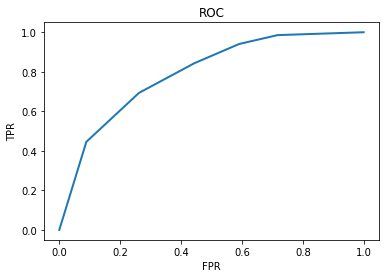

Area under curve is 0.7916726717263876
Confusion matrix is :
[[ 582  465]
 [ 367 1979]]
Accuracy is 0.7547892720306514
recall is 0.8435635123614663
precision is 0.8097381342062193
f1_score is 0.8263048016701462


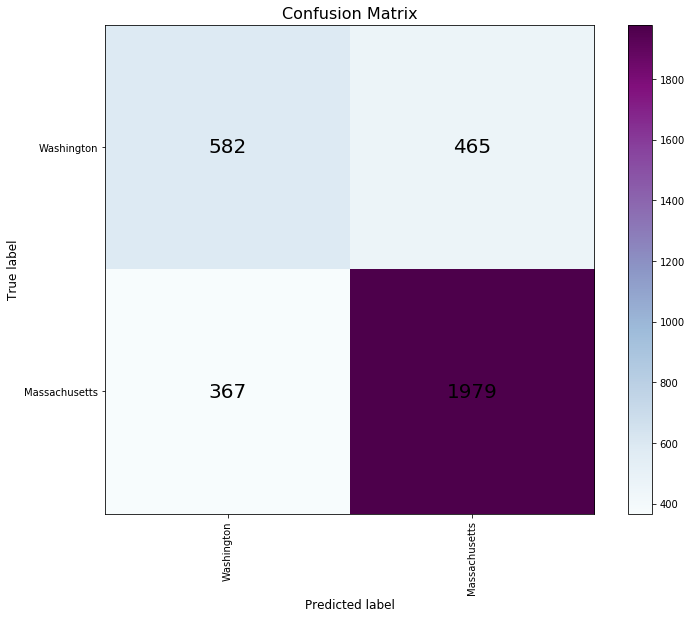

When n_neighbors = 10


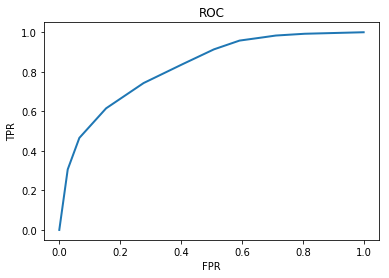

Area under curve is 0.8227263622528866
Confusion matrix is :
[[ 623  424]
 [ 379 1967]]
Accuracy is 0.7633362805776599
recall is 0.8384484228473998
precision is 0.822668339606859
f1_score is 0.8304834283301668


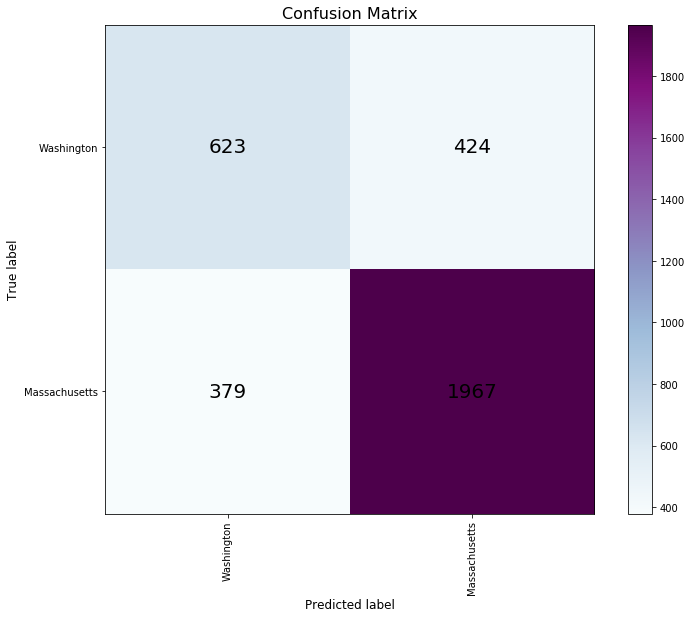

When n_neighbors = 15


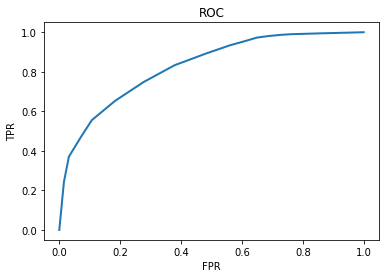

Area under curve is 0.8270913282052159
Confusion matrix is :
[[ 541  506]
 [ 251 2095]]
Accuracy is 0.7768936044798114
recall is 0.8930093776641091
precision is 0.8054594386774317
f1_score is 0.8469779664443097


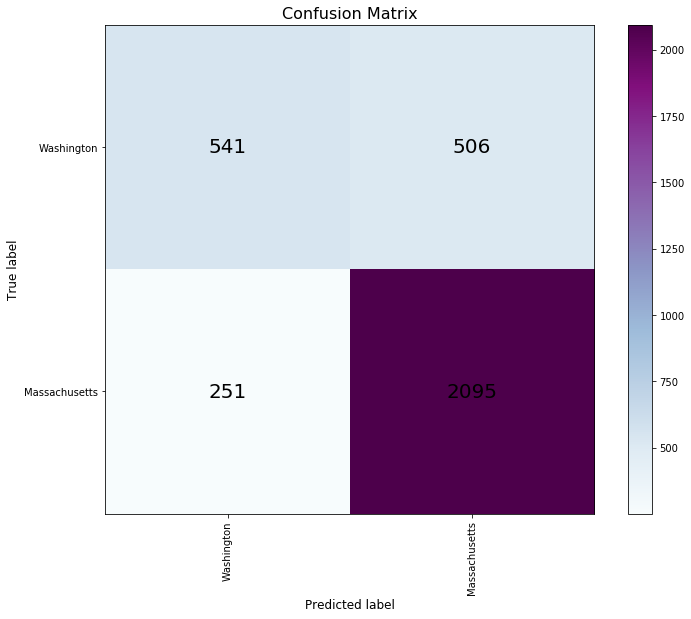

When n_neighbors = 20


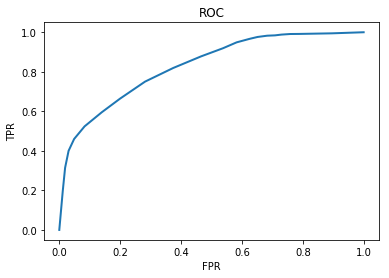

Area under curve is 0.828071883211156
Confusion matrix is :
[[ 559  488]
 [ 286 2060]]
Accuracy is 0.7718832891246684
recall is 0.8780903665814151
precision is 0.8084772370486656
f1_score is 0.8418471597874948


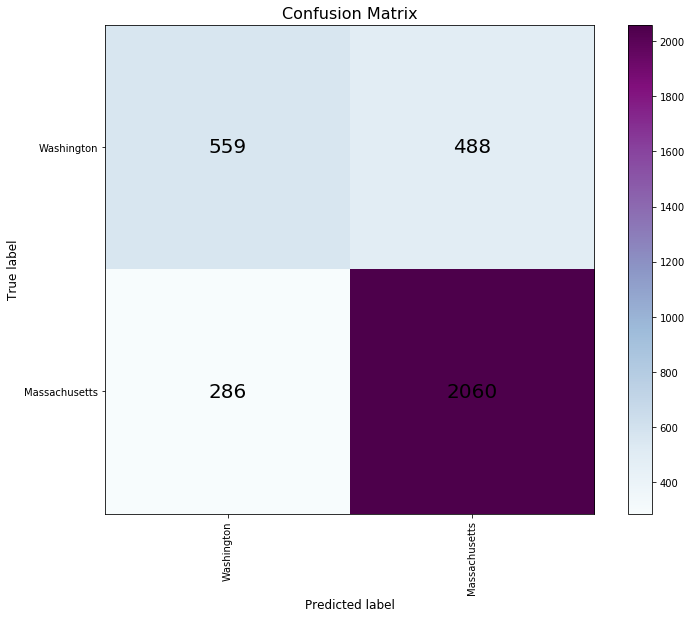

When n_neighbors = 30


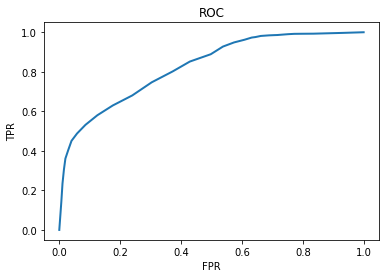

Area under curve is 0.8253673671619721
Confusion matrix is :
[[ 526  521]
 [ 261 2085]]
Accuracy is 0.7695254936634247
recall is 0.8887468030690537
precision is 0.8000767459708366
f1_score is 0.8420840064620356


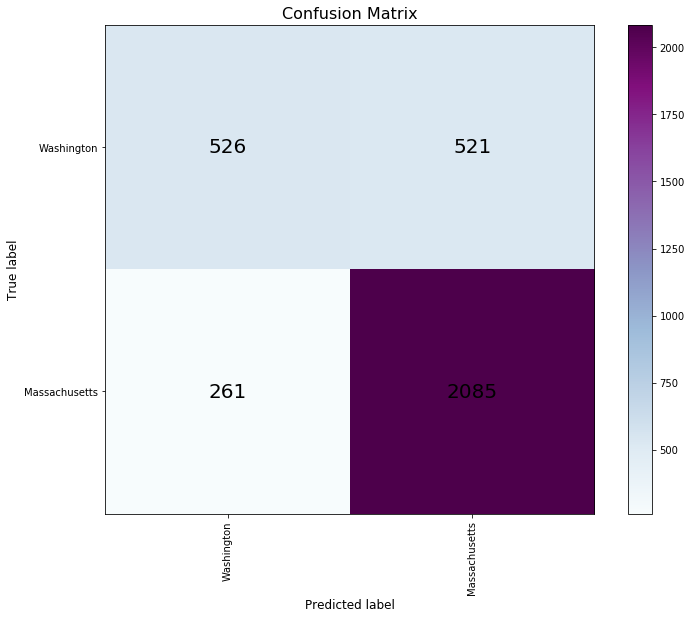

When n_neighbors = 40


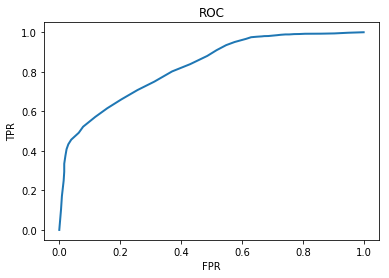

Area under curve is 0.8254540842955679
Confusion matrix is :
[[ 506  541]
 [ 213 2133]]
Accuracy is 0.7777777777777778
recall is 0.9092071611253197
precision is 0.7976813762154076
f1_score is 0.849800796812749


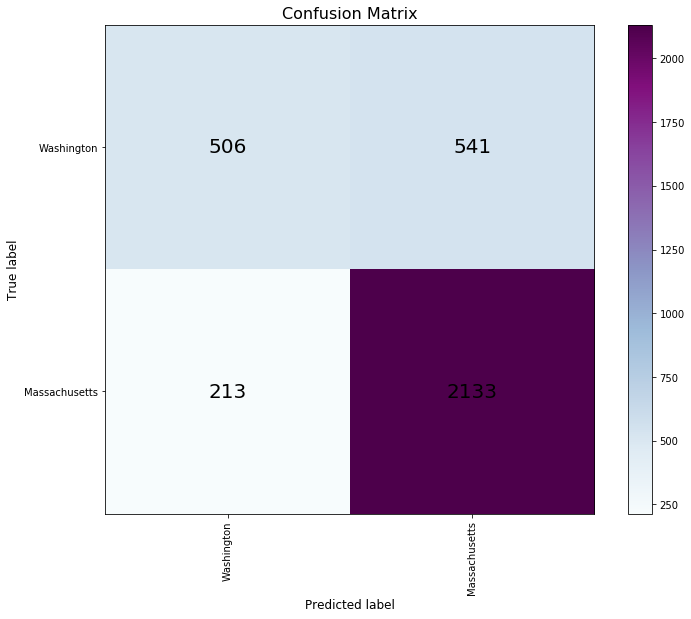

When n_neighbors = 50


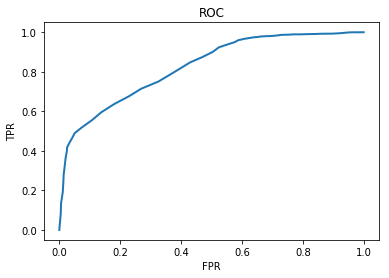

Area under curve is 0.8248723059673602
Confusion matrix is :
[[ 498  549]
 [ 179 2167]]
Accuracy is 0.7854406130268199
recall is 0.9236999147485081
precision is 0.7978645066273933
f1_score is 0.8561833267483209


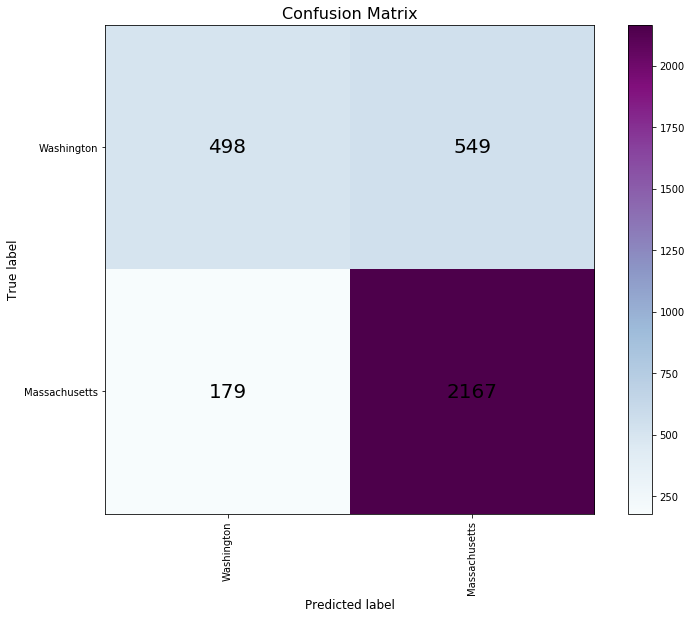

In [12]:
labels=np.array(mask)

n_neighbors=[5,10,15,20,30,40,50]

for n in n_neighbors:
    print('When n_neighbors = {}'.format(n))
    KNN_evaluation(data_svd,labels,n)

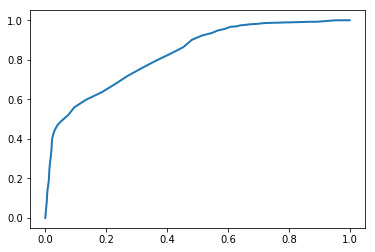

Area under curve is 0.827578246945969
Confusion matrix is :
[[ 508  539]
 [ 181 2165]]
Accuracy is 0.7877984084880637
recall is 0.922847399829497
precision is 0.8006656804733728
f1_score is 0.8574257425742575


In [121]:
#When n_neighbors = 50
KNN_evaluation(data_svd,labels,50)

# Gaussian NB (Naive Bayes)

In [13]:
def NB_evaluation(X,Y):
    train=int(0.9*len(X))
    NB_model=GaussianNB()
    X_train=X[0:train]
    Y_train=Y[0:train]
    X_val=X[train:]
    Y_val=Y[train:]
    NB_model.fit(X_train,Y_train)
    Y_pred=NB_model.predict(X_val)
    predict_score=NB_model.predict_proba(X_val)
    FPR,TPR,threshold=metrics.roc_curve(Y_val,predict_score[:,1])
    confusion_matrix=metrics.confusion_matrix(Y_val,Y_pred)
    accuracy=metrics.accuracy_score(Y_val,Y_pred)
    recall=metrics.recall_score(Y_val,Y_pred,average='binary')
    precision=metrics.precision_score(Y_val,Y_pred,average='binary')
    f1_score=metrics.f1_score(Y_val,Y_pred,average='binary')
    roc=metrics.auc(FPR,TPR)
    plt.plot(FPR,TPR,lw=2,label='area under curve=%0.4F' % roc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()
    plot_confusion_matrix(confusion_matrix,['Washington','Massachusetts'],'Confusion Matrix')
    print('Area under curve is {}'.format(roc))
    print("Confusion matrix is :")
    print(confusion_matrix)
    print('Accuracy is {}'.format(np.mean(accuracy)))
    print('recall is {}'.format(np.mean(recall)))
    print('precision is {}'.format(precision))
    print('f1_score is {}'.format(np.mean(f1_score)))
    

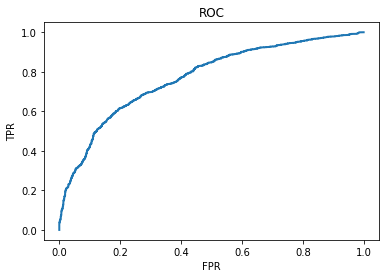

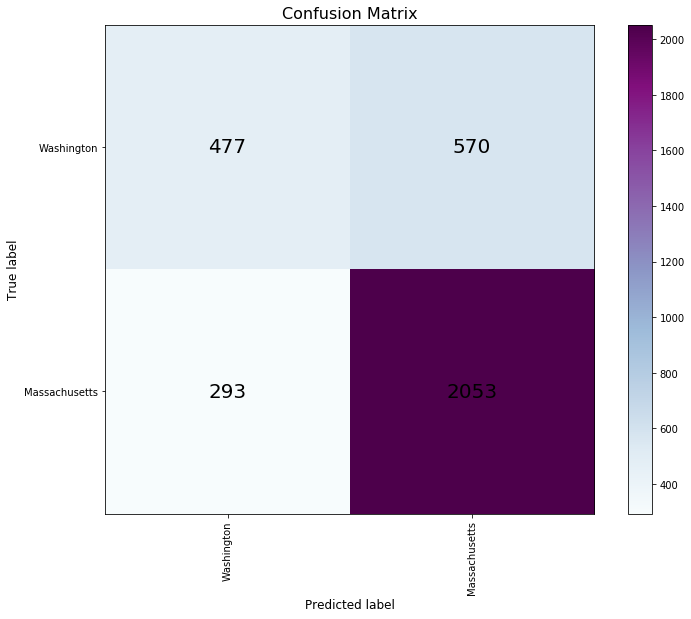

Area under curve is 0.7706464131269384
Confusion matrix is :
[[ 477  570]
 [ 293 2053]]
Accuracy is 0.7456528146183319
recall is 0.8751065643648764
precision is 0.7826915745329776
f1_score is 0.8263232038639565


In [14]:
NB_evaluation(data_svd,labels)

# Logistic Regression

In [15]:
def LR_evaluation(X,Y,regularization,strength):
    train=int(0.9*len(X))
    LR_model=LogisticRegression(penalty=regularization,C=strength,solver='liblinear')
    X_train=X[0:train]
    Y_train=Y[0:train]
    X_val=X[train:]
    Y_val=Y[train:]
    LR_model.fit(X_train,Y_train)
    Y_pred=LR_model.predict(X_val)
    predict_score=LR_model.predict_proba(X_val)
    FPR,TPR,threshold=metrics.roc_curve(Y_val,predict_score[:,1])
    confusion_matrix=metrics.confusion_matrix(Y_val,Y_pred)
    accuracy=metrics.accuracy_score(Y_val,Y_pred)
    recall=metrics.recall_score(Y_val,Y_pred,average='binary')
    precision=metrics.precision_score(Y_val,Y_pred,average='binary')
    f1_score=metrics.f1_score(Y_val,Y_pred,average='binary')
    roc=metrics.auc(FPR,TPR)
    plt.plot(FPR,TPR,lw=2,label='area under curve=%0.4F' % roc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()
    plot_confusion_matrix(confusion_matrix,['Washington','Massachusetts'],'Confusion Matrix')
    print('Area under curve is {}'.format(roc))
    print("Confusion matrix is :")
    print(confusion_matrix)
    print('Accuracy is {}'.format(np.mean(accuracy)))
    print('recall is {}'.format(np.mean(recall)))
    print('precision is {}'.format(precision))
    print('f1_score is {}'.format(np.mean(f1_score)))
    

When the regularization type is l1


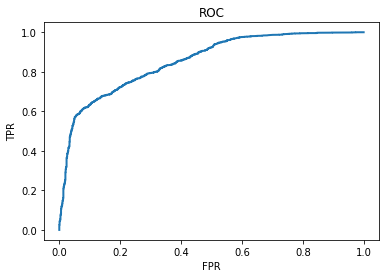

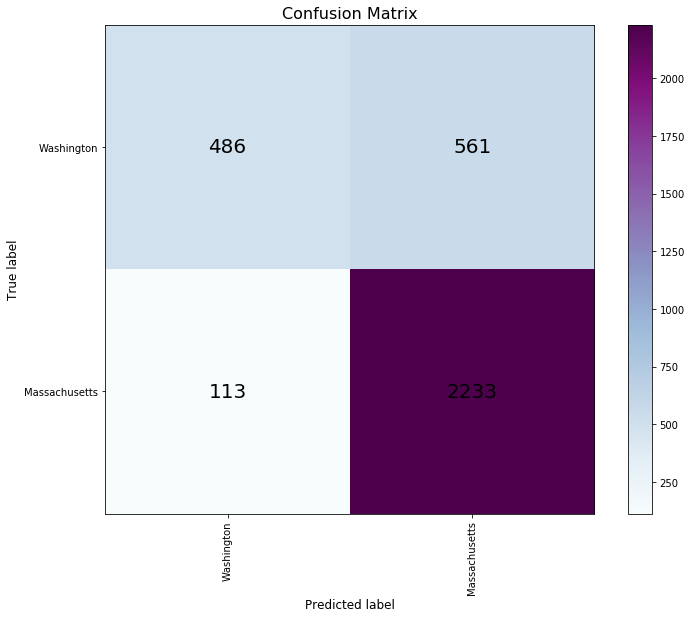

Area under curve is 0.8543219330836856
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394
When the regularization type is l2


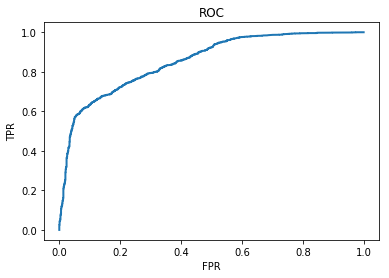

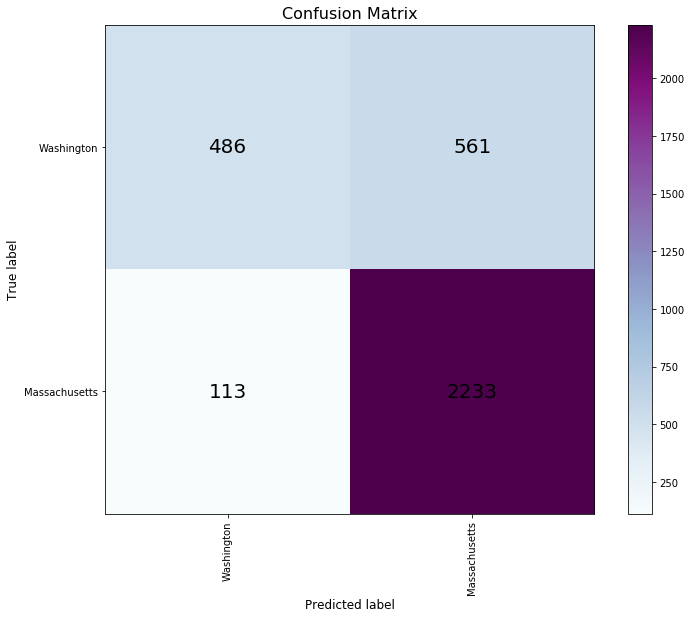

Area under curve is 0.8543268185560009
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394


In [16]:
regularization_list=['l1','l2']
for reg in regularization_list:
    print('When the regularization type is {}'.format(reg))
    LR_evaluation(data_svd,labels,reg,1000)

When the regularization strength is 1


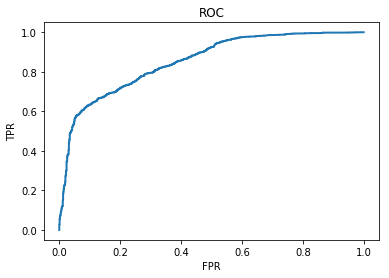

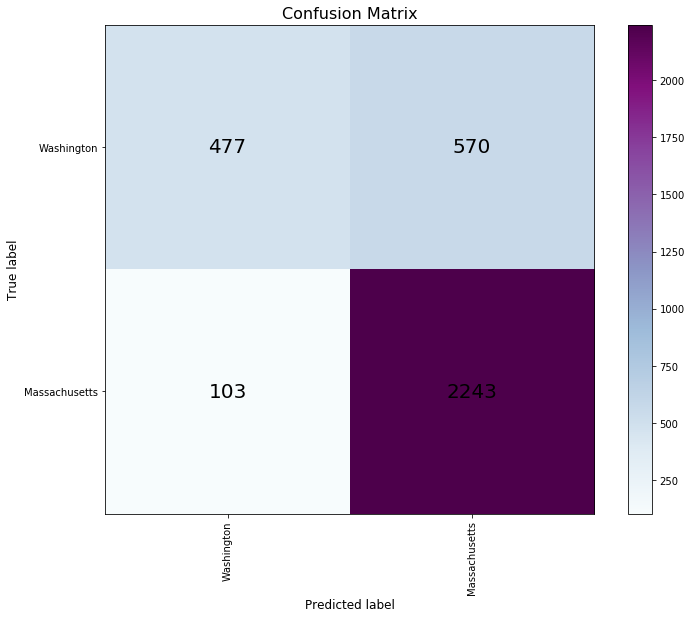

Area under curve is 0.8532870271982387
Confusion matrix is :
[[ 477  570]
 [ 103 2243]]
Accuracy is 0.8016504568228706
recall is 0.9560954816709293
precision is 0.797369356558834
f1_score is 0.8695483620856757
When the regularization strength is 10


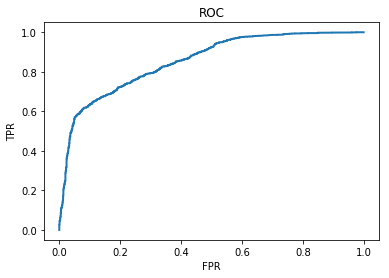

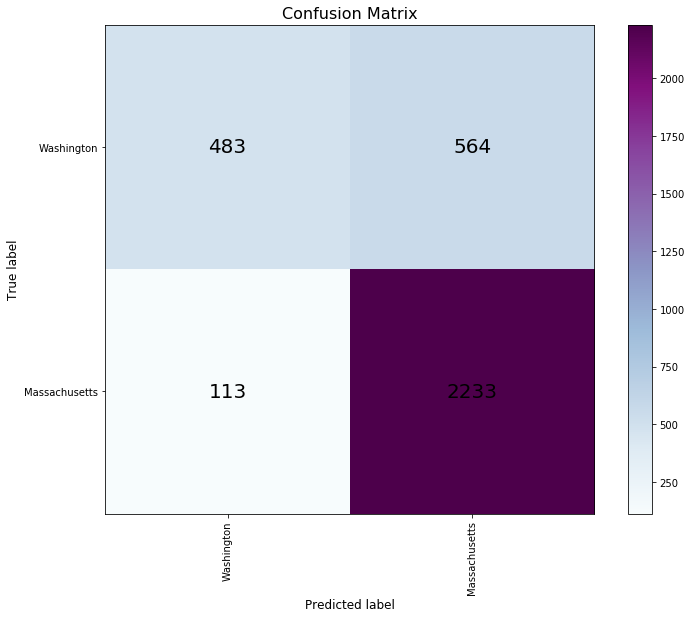

Area under curve is 0.8542865134094002
Confusion matrix is :
[[ 483  564]
 [ 113 2233]]
Accuracy is 0.8004715590922488
recall is 0.9518329070758739
precision is 0.7983553807651055
f1_score is 0.8683647676453432
When the regularization strength is 100.0


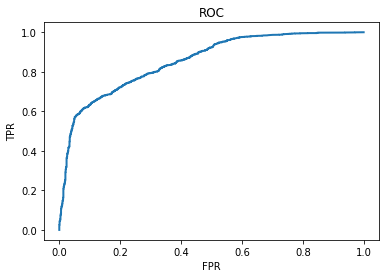

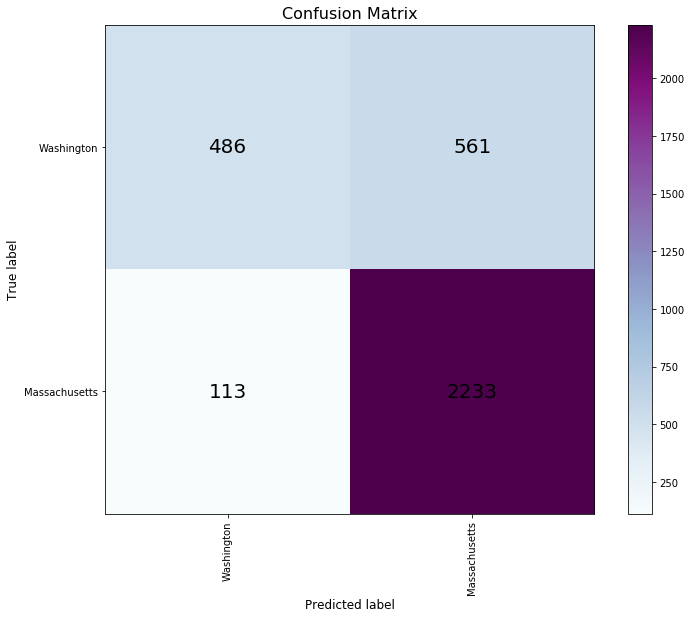

Area under curve is 0.854326411433308
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394
When the regularization strength is 1000.0


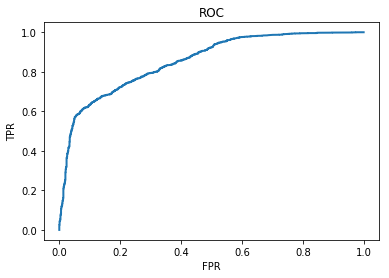

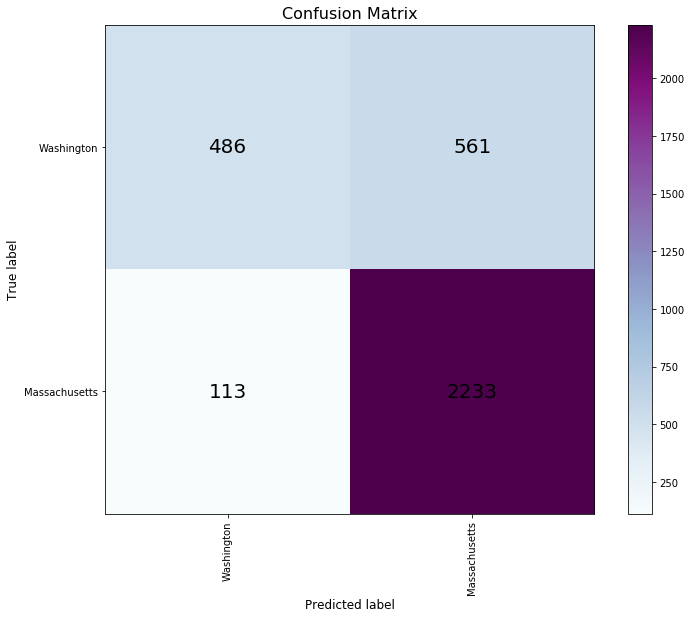

Area under curve is 0.8543268185560009
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394
When the regularization strength is 10000.0


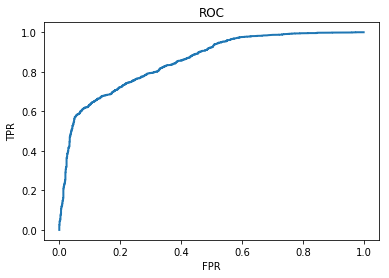

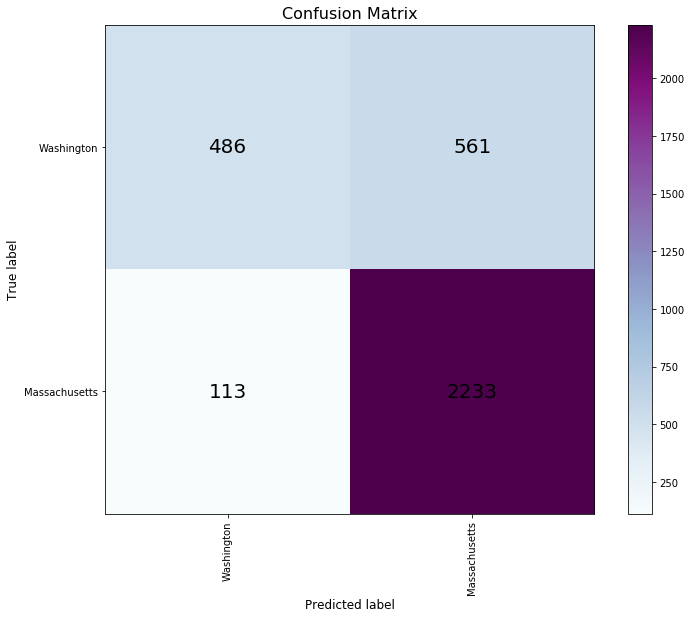

Area under curve is 0.8543247829425363
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394
When the regularization strength is 100000.0


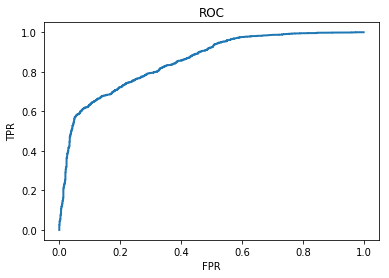

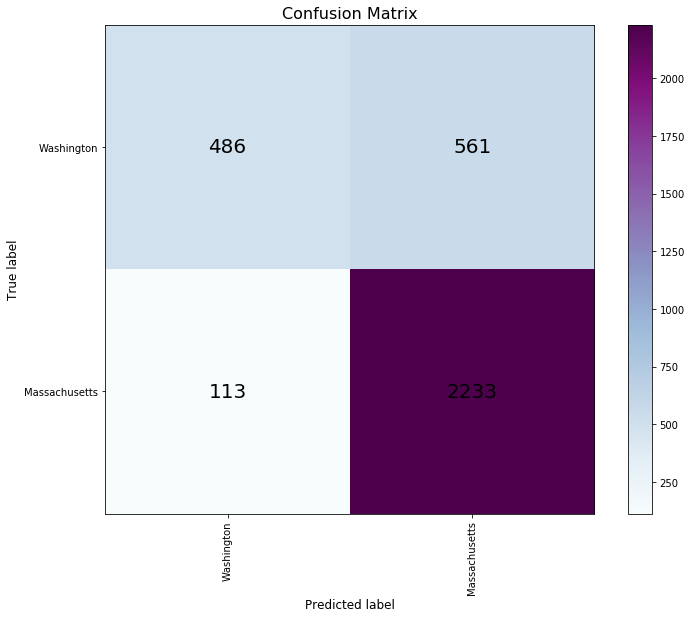

Area under curve is 0.8543239686971504
Confusion matrix is :
[[ 486  561]
 [ 113 2233]]
Accuracy is 0.8013557323902152
recall is 0.9518329070758739
precision is 0.7992125984251969
f1_score is 0.8688715953307394


In [17]:
strength_list=[1,10,1e2,1e3,1e4,1e5]
for c in strength_list:
    print('When the regularization strength is {}'.format(c))
    LR_evaluation(data_svd,labels,'l2',c)

# SVM

In [21]:
def svm_evaluation(X,Y,regularization,kernel,):
    train=int(0.9*len(X))
    svm_model=SVC(C=regularization,kernel=kernel,probability=True)
    X_train=X[0:train]
    Y_train=Y[0:train]
    X_val=X[train:]
    Y_val=Y[train:]
    svm_model.fit(X_train,Y_train)
    Y_pred=svm_model.predict(X_val)
    predict_score=svm_model.predict_proba(X_val)
    FPR,TPR,threshold=metrics.roc_curve(Y_val,predict_score[:,1])
    confusion_matrix=metrics.confusion_matrix(Y_val,Y_pred)
    accuracy=metrics.accuracy_score(Y_val,Y_pred)
    recall=metrics.recall_score(Y_val,Y_pred,average='binary')
    precision=metrics.precision_score(Y_val,Y_pred,average='binary')
    f1_score=metrics.f1_score(Y_val,Y_pred,average='binary')
    roc=metrics.auc(FPR,TPR)
    plt.plot(FPR,TPR,lw=2,label='area under curve=%0.4F' % roc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()
    plot_confusion_matrix(confusion_matrix,['Washington','Massachusetts'],'Confusion Matrix')
    print('Area under curve is {}'.format(roc))
    print("Confusion matrix is :")
    print(confusion_matrix)
    print('Accuracy is {}'.format(np.mean(accuracy)))
    print('recall is {}'.format(np.mean(recall)))
    print('precision is {}'.format(precision))
    print('f1_score is {}'.format(np.mean(f1_score)))
    

When the regularization strength is 1


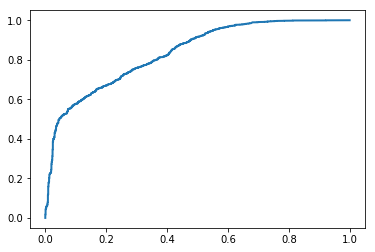

Area under curve is 0.8354277760271502
Confusion matrix is :
[[ 464  583]
 [ 115 2231]]
Accuracy is 0.794282346006484
recall is 0.9509803921568627
precision is 0.7928216062544421
f1_score is 0.8647286821705427
When the regularization strength is 10


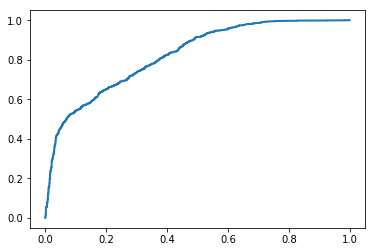

Area under curve is 0.8230459535668426
Confusion matrix is :
[[ 502  545]
 [ 180 2166]]
Accuracy is 0.7863247863247863
recall is 0.9232736572890026
precision is 0.7989671707856879
f1_score is 0.8566343682024916
When the regularization strength is 100.0


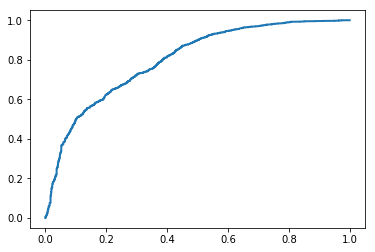

Area under curve is 0.8004347663237881
Confusion matrix is :
[[ 535  512]
 [ 256 2090]]
Accuracy is 0.7736516357206012
recall is 0.8908780903665814
precision is 0.8032282859338971
f1_score is 0.8447857720291027


In [20]:
strength_list=[1,10,1e2]
for c in strength_list:
    print('When the regularization strength is {}'.format(c))
    svm_evaluation(data_svd,labels,c,'rbf')
    

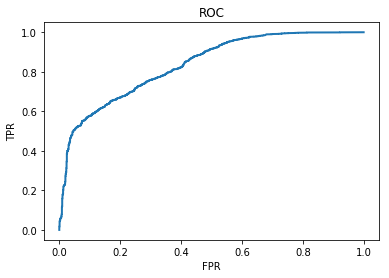

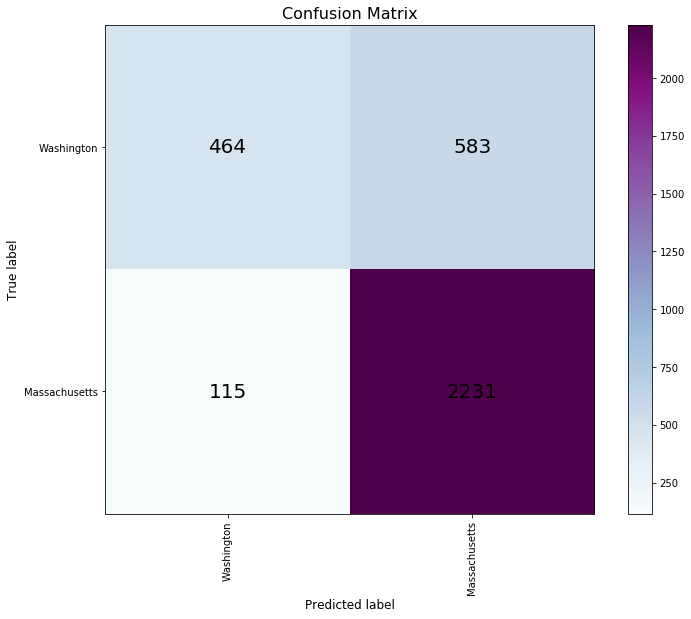

Area under curve is 0.8354546461248841
Confusion matrix is :
[[ 464  583]
 [ 115 2231]]
Accuracy is 0.794282346006484
recall is 0.9509803921568627
precision is 0.7928216062544421
f1_score is 0.8647286821705427


In [22]:
svm_evaluation(data_svd,labels,1,'rbf')

In [ ]:
kernel_list=['rbf','linear','poly','sigmoid']
for c in strength_list:
    print('When the regularization strength is {}'.format(c))
    svm_evaluation(data_svd,labels,c,'rbf')